# Importazione delle librerie

<a target="_blank" href="https://colab.research.google.com/github/socrates77/snn-tre/blob/main/notebooks/Rate-coding-luminosita-di-un-pixel.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%pip install snnTorch

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import io
from PIL import Image
import torch
from snntorch import spikegen
from snntorch import spikeplot as splt

## Classi per la gestione dei parametri variabili

In [2]:
class Threshold:
    v_threshold=0.09
    def __init__(self, v_threshold=0.09):
        self.v_threshold = v_threshold
    def set_v_threshold(self, v_threshold):
        self.v_threshold = v_threshold
    def get_v_threshold(self):
        return self.v_threshold
    
class PixelIntensity:
    pixel_intensity=0.0
    def set_pixel_intensity(self, pixel_intensity):
        self.pixel_intensity = pixel_intensity;
    def get_pixel_intensity(self):
        return self.pixel_intensity

v_th_obj = Threshold()
pixel_intensity = PixelIntensity()

## Modello e funzione per graficare

In [3]:
output = widgets.Output()

def lif_neuron(v, time_step=1e-3, v_th=35e-3, I=0, R=5e7, C=1e-10):
  '''
  Implementazione del modello Leaky Integrate and Fire in python.
  '''
  tau=R*C
  spk = (v>=v_th)
  # Sottraggo la tensione di soglia quando ho un spike
  v = v + (time_step/tau)*(-v + I*R) - (spk*v_th) 
    
  return v, spk

def v_mem_spike_plot(time_vector, v_mem, spk_rec, I=[], filename='figure.eps', format='eps', title=''):
  # Creare la figura
  spike_record = [1 if element == 1 else None for element in spk_rec]
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 9), height_ratios=[10, 1]) # crea la figura e gli assi
  fig.tight_layout()
  axs[0].set_title(title)
  
  if ( len(I) != 0 and len(I) == len(v_mem) ):
    axs_1 = axs[0].twinx()
    axs[0].plot(time_vector, v_mem, scaley=True) # disegna il grafico della tensione ai capi del condensatore
    axs_1.set_ylabel('$I_{syn}$', color='r')
    axs_1.plot(time_vector, I, 'r-', scaley=True)
  else:
    axs[0].plot(time_vector, v_mem) # disegna il grafico della tensione ai capi del condensatore

  axs[0].set_xlim((-2, len(time_vector) + 2))
  axs[0].set_xlabel('Tempo') # aggiungi l'etichetta all'asse x
  axs[0].set_ylabel('Potenziale di membrana') # aggiungi l'etichetta all'asse y

  axs[1].scatter(time_vector, spike_record, marker='|', color=['b'])
  axs[1].set_yticks([])
  axs[1].set_xlim((-2, 202))
  axs[1].set_xlabel('Tempo') # aggiungi l'etichetta all'asse x
  axs[1].set_ylabel('Spikes') # aggiungi l'etichetta all'asse y

  # Salvare la figura in formato EPS
  fig.savefig(filename, format=format)

  with output:
    output.clear_output(wait=True)
    plt.show()

## Widgets

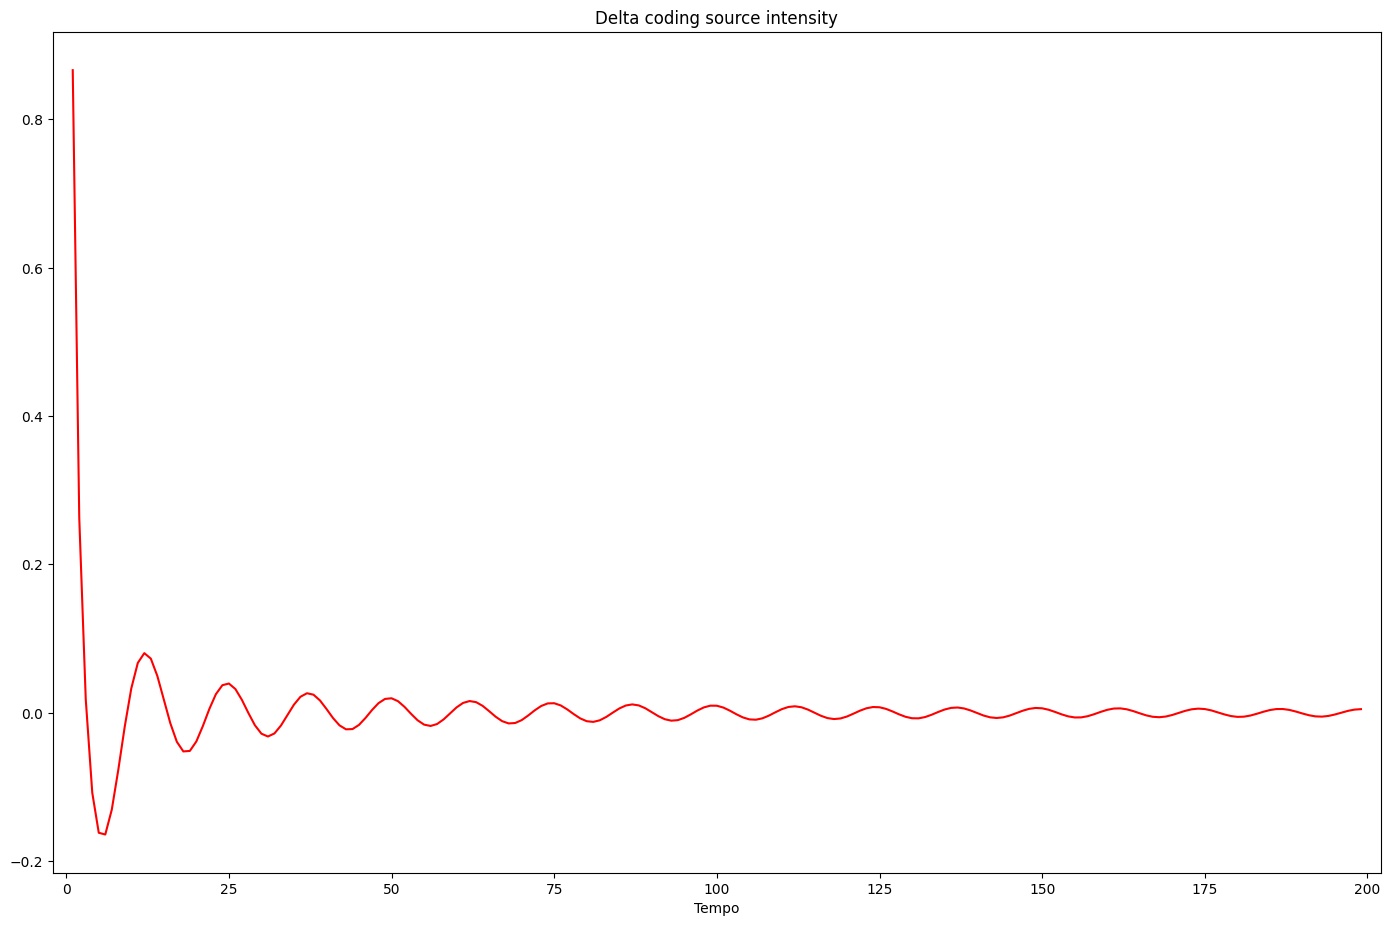

In [4]:
pixel_intensity_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=3,
    description='Pixel Intensity:',
    orientation='vertical',
    readout=True,
    # readout_format='.2f',
)

v_threshold_slider = widgets.FloatSlider(
    value=0.09,
    min=0.09,
    max=1.0,
    step=0.01,
    description='Threshold:',
    orientation='vertical',
    readout=True,
    readout_format='.2f',
)

# Creiamo un widget Image per mostrare il pixel
pixel_image = widgets.Image(
    format='jpeg',
    width=100,
    height=100,
)


input_current = torch.cos( torch.linspace(0, 32*np.pi, 200) )

input_current = input_current/torch.linspace(0, 64*np.pi, 200)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 9)) # crea la figura e gli assi
fig.tight_layout()
title="Delta coding source intensity"
axs.set_title(title)
axs.plot(torch.arange(0,len(input_current)), input_current, 'r-')
axs.set_xlim(-2, (len(input_current) + 2))
axs.set_xlabel('Tempo') # aggiungi l'etichetta all'asse x
axs.set_ylabel('') # aggiungi l'etichetta all'asse y
filename="delta-coding-source-intensity.eps"
format="eps"
# Salvare la figura in formato EPS
fig.savefig(filename, format=format)


def init_pixel_image():
    pixel_intensity_value=0.0
    image_array = np.ones( (100,100), dtype=np.uint8 )*pixel_intensity_value
    # Convertiamo l'array in un oggetto immagine JPEG
    pil_image = Image.fromarray(image_array)
    pil_image = pil_image.convert('L')
    byte_io = io.BytesIO()
    pil_image.save(byte_io, 'jpeg')
    image_data = byte_io.getvalue()
    pixel_image.value = image_data

def update_pixel_image(change):
    pixel_intensity_value=change.new
    image_array = np.ones( (100,100), dtype=np.uint8 )*pixel_intensity_value
    # Convertiamo l'array in un oggetto immagine JPEG
    pil_image = Image.fromarray(image_array)
    pil_image = pil_image.convert('L')
    byte_io = io.BytesIO()
    pil_image.save(byte_io, 'jpeg')
    image_data = byte_io.getvalue()
    pixel_image.value = image_data

def update_v_threshold(change):
    v_th_obj.set_v_threshold(change.new)
    run_network(pixel_intensity.get_pixel_intensity()*input_current, v_th_obj.get_v_threshold())

def update_pixel(change):
    pixel_intensity.set_pixel_intensity(change.new)
    run_network(pixel_intensity.get_pixel_intensity()*input_current, v_th_obj.get_v_threshold())

def run_network(pixel_intensity_value, v_threshold):
    spike_vector = spikegen.delta(pixel_intensity_value)
    
    spike_vector = spike_vector*1e-8
    prev = 0.0
    spk = 0.0
    spk_rec = torch.zeros_like(spike_vector)
    v_mem = torch.zeros_like(spike_vector)
    time_vector = range(0, len(spike_vector))

    for i in time_vector:
        I = spike_vector[i]
        v_mem[i] = prev
        spk_rec[i] = spk
        prev, spk = lif_neuron(prev, I=I, v_th=v_threshold)
    figure="../figures/delta-coding-spike-intensity-{:.2f}-threshold-{:.2f}.eps".format( pixel_intensity.get_pixel_intensity(), v_threshold )
    title="Delta coding, Pixel Intensity {:.2f}, Threshold: {:.2f}".format( pixel_intensity.get_pixel_intensity(), v_threshold )
    v_mem_spike_plot(time_vector, v_mem, spk_rec, spike_vector, filename=figure, title=title)


In [5]:
init_pixel_image()
run_network(pixel_intensity.get_pixel_intensity()*input_current, v_th_obj.get_v_threshold())
v_threshold_slider.observe(update_v_threshold, names='value')
pixel_intensity_slider.observe(update_pixel, names='value')
pixel_intensity_slider.observe(update_pixel_image, names='value')
container = widgets.HBox(children=[ pixel_intensity_slider, v_threshold_slider, pixel_image ] )
display( widgets.VBox(children=[ container, output ] ) )